In [74]:
#!pip install wordcloud
import numpy as np
import pandas as pd
#!pip install contractions
import nltk
nltk.download('punkt')  # For tokenization
nltk.download('stopwords')  # For stopwords
import string
import contractions
import re
import random
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

#modelling
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

#model evaluation
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc
from sklearn.preprocessing import label_binarize

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

#!pip install tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abbie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abbie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv('cyberbullying_tweets.csv')

In [3]:
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [4]:
df.columns

Index(['tweet_text', 'cyberbullying_type'], dtype='object')

In [5]:
df['cyberbullying_type'].value_counts()

cyberbullying_type
religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: count, dtype: int64

In [6]:
types = []

for i in df['cyberbullying_type'].unique():
    types.append(i)
    
print(types)

['not_cyberbullying', 'gender', 'religion', 'other_cyberbullying', 'age', 'ethnicity']


In [7]:
df['hate_speech'] = df['cyberbullying_type'].apply(lambda x: 1 if x in types[1:] else 0)

In [8]:
df['hate_speech'].value_counts()

hate_speech
1    39747
0     7945
Name: count, dtype: int64

In [9]:
num_zeros = df[df['hate_speech'] == 0].shape[0]

In [10]:
sampled_ones = df[df['hate_speech'] == 1].sample(n=num_zeros, random_state=42)

In [11]:
sampled_ones.columns

Index(['tweet_text', 'cyberbullying_type', 'hate_speech'], dtype='object')

In [12]:
df = pd.concat([df[df['hate_speech'] == 0], sampled_ones], axis=0)

In [13]:
df.shape

(15890, 3)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15890 entries, 0 to 47441
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          15890 non-null  object
 1   cyberbullying_type  15890 non-null  object
 2   hate_speech         15890 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 496.6+ KB


In [15]:
df.head()

,tweet_text,cyberbullying_type,hate_speech
0,"In other words #katandandre, your food was cra...",not_cyberbullying,0
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,0
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,0
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,0
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,0


# Pre-Processing

In [16]:
ps = PorterStemmer()
STOP_WORDS = set(stopwords.words('english'))

EMOTICONS = {
    u':‑)':'Happy face or smiley',
    u':)':'Happy face or smiley',
    u':-]':'Happy face or smiley',
    u':]':'Happy face or smiley',
    u':-3':'Happy face smiley',
    u':3':'Happy face smiley',
    u':->':'Happy face smiley',
    u':>':'Happy face smiley',
    u'8-)':'Happy face smiley',
    u':o)':'Happy face smiley',
    u':-}':'Happy face smiley',
    u':}':'Happy face smiley',
    u':-)':'Happy face smiley',
    u':c)':'Happy face smiley',
    u':^)':'Happy face smiley',
    u'=]':'Happy face smiley',
    u': P':'Happy face smiley',
    u':P':'Happy face smiley'
    }

def strip_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002500-\U00002BEF"  # chinese characters
                           u"\U00002702-\U000027B0"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\U0001f926-\U0001f937"
                           u"\U00010000-\U0010ffff"
                           u"\u2640-\u2642" 
                           u"\u2600-\u2B55"
                           u"\u200d"
                           u"\u23cf"
                           u"\u23e9"
                           u"\u231a"
                           u"\ufe0f"  # dingbats
                           u"\u3030"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def clean_text(text):
    text = strip_emoji(text)
    # Remove Twitter handles
    text = re.sub(r'@\w+', '', text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])
    
    # Remove numbers
    text = ''.join([i for i in text if not i.isdigit()])
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Optionally: Stemming and removing stopwords (if not handled by the pipeline)
    text = ' '.join([ps.stem(word) for word in text.split() if word not in STOP_WORDS and len(word) > 2])
    
    return text

In [17]:
df['text'] = df['tweet_text'].astype(str)
df['text'] = df['text'].apply(clean_text)

In [18]:
df['text'].head(20)

0                    word katandandr food crapilici mkr
1     aussietv white mkr theblock imacelebrityau tod...
2                        classi whore red velvet cupcak
3       meh thank head concern anoth angri dude twitter
4     isi account pretend kurdish account like islam...
5     ye test god good bad indiffer weird whatev pro...
6       itu sekolah bukan tempat bulli jauh kaya neraka
7                    karma hope bite kat butt nasti mkr
8                                 everyth mostli priest
9                   rebecca black drop school due bulli
10                                                     
11                                          bulli flush
12                                           ughhhh mkr
13    turkish state kill children last year news goo...
14    love best respons hotcak manag film noncommitt...
15         parem fazer bulli comigo uhahuah bando preto
16                   tadinhu mim sofrendo bull viu mimi
17                     twitter basic angri lette

In [19]:
df.head()

,tweet_text,cyberbullying_type,hate_speech,text
0,"In other words #katandandre, your food was cra...",not_cyberbullying,0,word katandandr food crapilici mkr
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,0,aussietv white mkr theblock imacelebrityau tod...
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,0,classi whore red velvet cupcak
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,0,meh thank head concern anoth angri dude twitter
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,0,isi account pretend kurdish account like islam...


# Model for Binary

Naive Bayes, Logistic Regression, and Random Forest


In [20]:
vec = TfidfVectorizer()
le = LabelEncoder()

In [21]:
X = df['text']
y = df['hate_speech']

In [22]:
y = le.fit_transform(y)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
#Random Forest
pipeline_rf = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('svd', TruncatedSVD(n_components=100)),
    ('clf', RandomForestClassifier())
    ])

In [25]:
pipeline_rf.fit(X_train, y_train)
predictions_rf = pipeline_rf.predict(X_test)

In [26]:
#logistic Regression

pipeline_lr = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('svd', TruncatedSVD(n_components=100)),
    ('clf', LogisticRegression(max_iter=10000))
])


In [27]:
pipeline_lr.fit(X_train, y_train)
predictions_lr = pipeline_lr.predict(X_test)

In [28]:
# Naive Bayes
pipeline_nb = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('clf', MultinomialNB())
])

In [29]:
pipeline_nb.fit(X_train, y_train)
predictions_nb = pipeline_nb.predict(X_test)

In [30]:
# Model Evaluation
print("RF Classification Report:")
print(classification_report(y_test,predictions_rf))

print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, predictions_lr))

print("\nNaive Bayes Classification Report:")
print(classification_report(y_test, predictions_nb))

RF Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.83      0.81      1576
           1       0.82      0.78      0.80      1602

    accuracy                           0.81      3178
   macro avg       0.81      0.81      0.81      3178
weighted avg       0.81      0.81      0.81      3178


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.89      0.82      1576
           1       0.87      0.74      0.80      1602

    accuracy                           0.81      3178
   macro avg       0.82      0.81      0.81      3178
weighted avg       0.82      0.81      0.81      3178


Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.72      0.77      1576
           1       0.76      0.84      0.79      1602

    accuracy                           0.78      3178
   macro avg       0.7

In [31]:
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(title)

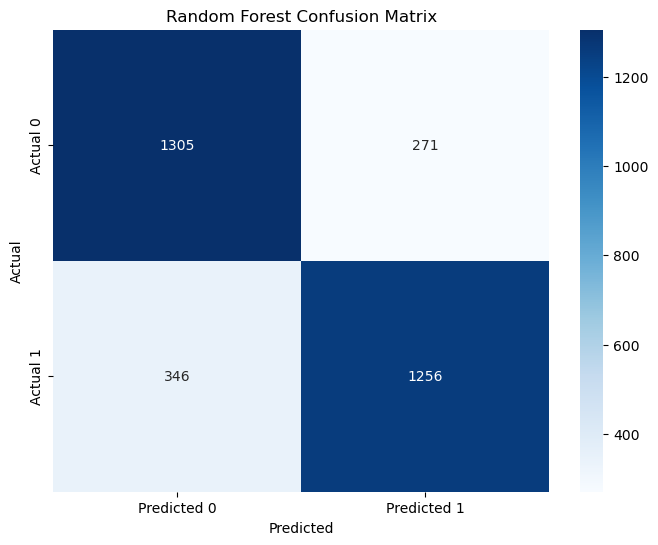

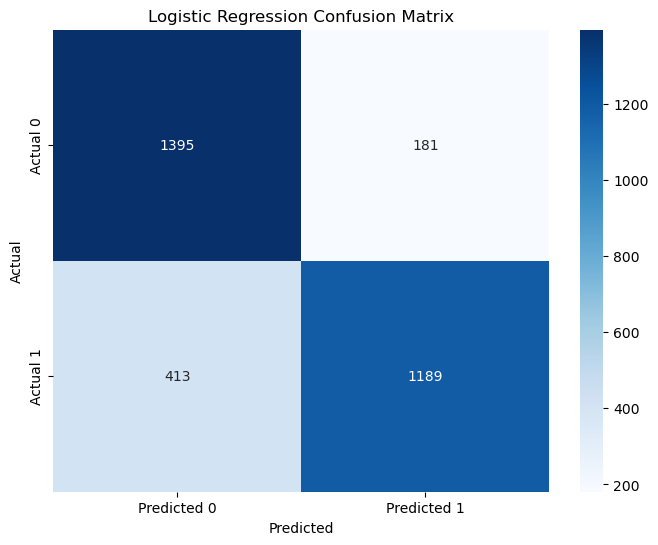

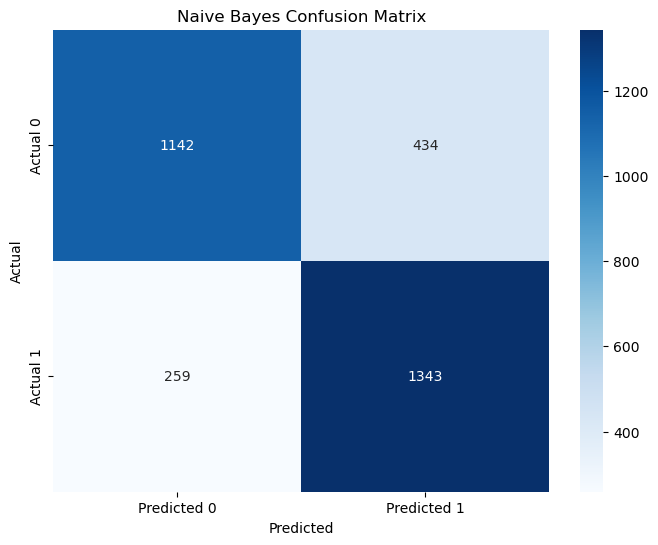

In [32]:
# Random Forest Confusion Matrix
cm_rf = confusion_matrix(y_test, predictions_rf)
plot_confusion_matrix(cm_rf, 'Random Forest Confusion Matrix')

# Logistic Regression Confusion Matrix
cm_lr = confusion_matrix(y_test, predictions_lr)
plot_confusion_matrix(cm_lr, 'Logistic Regression Confusion Matrix')

# Naive Bayes Confusion Matrix
cm_nb = confusion_matrix(y_test, predictions_nb)
plot_confusion_matrix(cm_nb, 'Naive Bayes Confusion Matrix')

plt.show()


# Text-Specific Paramter Tuning

In [33]:
#Random Forest
pipeline_rf = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000,
                              ngram_range=(1, 2),          
                              max_df=0.9)), 
    ('svd', TruncatedSVD(n_components=100)),
    ('clf', RandomForestClassifier())
    ])

pipeline_rf.fit(X_train, y_train)
predictions_rf = pipeline_rf.predict(X_test)

#logistic Regression

pipeline_lr = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000,
                              ngram_range=(1, 2),      
                              max_df=0.9)), 
    ('svd', TruncatedSVD(n_components=100)),
    ('clf', LogisticRegression(max_iter=10000))
])
pipeline_lr.fit(X_train, y_train)
predictions_lr = pipeline_lr.predict(X_test)

# Naive Bayes
pipeline_nb = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000,
                              ngram_range=(1, 2),      
                              max_df=0.9)), 
    ('clf', MultinomialNB())
])
pipeline_nb.fit(X_train, y_train)
predictions_nb = pipeline_nb.predict(X_test)

In [34]:
# Model Evaluation
print("RF Classification Report:")
print(classification_report(y_test,predictions_rf))

print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, predictions_lr))

print("\nNaive Bayes Classification Report:")
print(classification_report(y_test, predictions_nb))

RF Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.84      0.81      1576
           1       0.83      0.78      0.80      1602

    accuracy                           0.81      3178
   macro avg       0.81      0.81      0.81      3178
weighted avg       0.81      0.81      0.81      3178


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.88      0.83      1576
           1       0.87      0.75      0.80      1602

    accuracy                           0.82      3178
   macro avg       0.82      0.82      0.82      3178
weighted avg       0.82      0.82      0.82      3178


Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.76      0.78      1576
           1       0.78      0.83      0.80      1602

    accuracy                           0.79      3178
   macro avg       0.7

# Part 2: Better Preprocessing

In [35]:
df = pd.read_csv('cyberbullying_tweets.csv')

In [36]:
df.shape

(47692, 2)

In [37]:
df.drop_duplicates(subset='tweet_text',keep='first', inplace=True)

In [38]:
df.shape

(46017, 2)

<Axes: xlabel='length', ylabel='Density'>

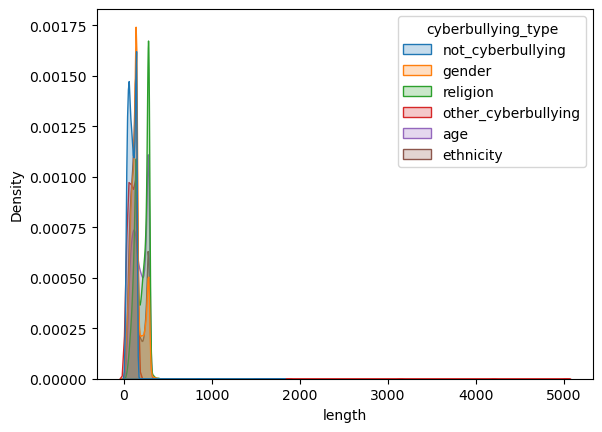

In [39]:
df['length'] = df['tweet_text'].apply(len)
df.head()

# Plot Distribution length words
sns.kdeplot(df,x=df['length'],hue='cyberbullying_type',fill=True)

In [40]:
from collections import Counter
import re

import nltk
from nltk.corpus import stopwords

In [41]:
# Concatenate all tweet texts into a single string
all_text = ' '.join(df['tweet_text'].values)
# Remove URLs, mentions, and hashtags from the text
all_text = re.sub(r'http\S+', '', all_text)
all_text = re.sub(r'@\S+', '', all_text)
all_text = re.sub(r'#\S+', '', all_text)
# Split the text into individual words
words = all_text.split()

In [42]:
# Count the frequency of each word
word_counts = Counter(words)
top_words = word_counts.most_common(100)
top_words

[('the', 27075),
 ('a', 22884),
 ('to', 22130),
 ('and', 19468),
 ('I', 15578),
 ('of', 14727),
 ('in', 13851),
 ('you', 13819),
 ('is', 12884),
 ('that', 10059),
 ('are', 8312),
 ('for', 8016),
 ('school', 6681),
 ('was', 6229),
 ('me', 6207),
 ('not', 6116),
 ('my', 5706),
 ('it', 5627),
 ('on', 5613),
 ('like', 5178),
 ('be', 5120),
 ('who', 5055),
 ('with', 5012),
 ('but', 4908),
 ('about', 4645),
 ('high', 4640),
 ('they', 4500),
 ('have', 4491),
 ('this', 4459),
 ('dumb', 4384),
 ('bullied', 4266),
 ('as', 4117),
 ('all', 4080),
 ('RT', 4046),
 ('i', 4008),
 ('just', 3748),
 ('your', 3732),
 ('people', 3725),
 ('so', 3561),
 ('at', 3383),
 ('u', 3235),
 ('or', 3156),
 ('by', 3102),
 ('rape', 3020),
 ('fuck', 3012),
 ('if', 2799),
 ('when', 2777),
 ('one', 2749),
 ('bully', 2724),
 ('from', 2713),
 ('gay', 2685),
 ('he', 2675),
 ('do', 2620),
 ('an', 2565),
 ('&amp;', 2560),
 ('up', 2518),
 ('being', 2502),
 ('what', 2491),
 ('The', 2488),
 ('You', 2463),
 ('nigger', 2441),
 ('ass

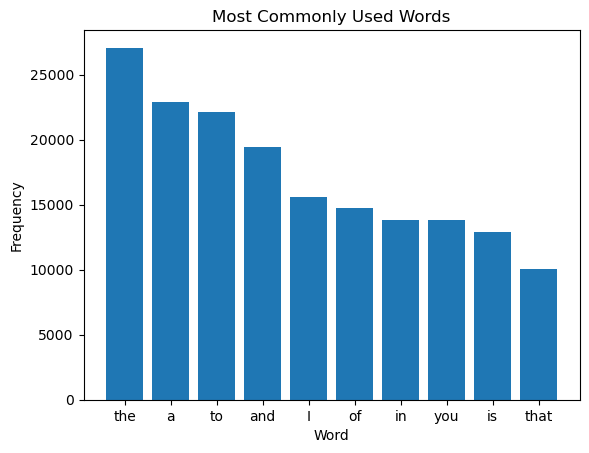

In [43]:
# Create a bar chart of the most common words
top_words = word_counts.most_common(10) # Change the number to show more/less words
x_values = [word[0] for word in top_words]
y_values = [word[1] for word in top_words]
plt.bar(x_values, y_values)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Most Commonly Used Words')
plt.show()

In [44]:
df['text']= df['tweet_text'].apply(clean_text)
df['text'].duplicated().sum()

1583

In [45]:
df.drop_duplicates(subset='text',keep='first', inplace=True)

In [46]:
df.shape

(44434, 4)

In [47]:
df['cyberbullying_type'].value_counts()

cyberbullying_type
religion               7956
age                    7872
ethnicity              7724
not_cyberbullying      7594
gender                 7580
other_cyberbullying    5708
Name: count, dtype: int64

In [48]:
df.describe()

,length
count,44434.000000
mean,140.844398
std,85.440941
min,3.000000
25%,83.000000
50%,127.000000
75%,193.000000
max,5018.000000


In [49]:
df['length'].median()

127.0

In [50]:
percentile_95 = df['length'].quantile(0.95)
print("95th percentile of text length:", percentile_95)

95th percentile of text length: 278.0


In [51]:
percentile_05 = df['length'].quantile(0.05)
print("05th percentile of text length:", percentile_05)

05th percentile of text length: 38.0


In [52]:
df = df[df['length'] > percentile_05]
df = df[df['length'] < percentile_95]

In [53]:
df['cyberbullying_type'].value_counts()

cyberbullying_type
ethnicity              7212
age                    7132
gender                 7055
religion               6934
not_cyberbullying      6517
other_cyberbullying    5026
Name: count, dtype: int64

In [54]:
df['hate_speech'] = df['cyberbullying_type'].apply(lambda x: 1 if x in types[1:] else 0)

In [55]:
num_zeros = df[df['hate_speech'] == 0].shape[0]

In [56]:
sampled_ones = df[df['hate_speech'] == 1].sample(n=num_zeros, random_state=42)

In [57]:
df = pd.concat([df[df['hate_speech'] == 0], sampled_ones], axis=0)

In [58]:
df.shape

(13034, 5)

In [59]:
df['hate_speech'].value_counts()

hate_speech
0    6517
1    6517
Name: count, dtype: int64

In [60]:
df.head()

,tweet_text,cyberbullying_type,length,text,hate_speech
0,"In other words #katandandre, your food was cra...",not_cyberbullying,61,word katandandr food crapilici mkr,0
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,115,aussietv white mkr theblock imacelebrityau tod...,0
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,60,classi whore red velvet cupcak,0
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,103,meh thank head concern anoth angri dude twitter,0
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,103,isi account pretend kurdish account like islam...,0


# Model

In [61]:
vec = TfidfVectorizer()
le = LabelEncoder()

In [62]:
X = df['text']
y = df['hate_speech']

In [63]:
y = le.fit_transform(y)

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [65]:
#Random Forest
pipeline_rf = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('svd', TruncatedSVD(n_components=100)),
    ('clf', RandomForestClassifier())
    ])

In [66]:
pipeline_rf.fit(X_train, y_train)
predictions_rf = pipeline_rf.predict(X_test)

In [67]:
#logistic Regression

pipeline_lr = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('svd', TruncatedSVD(n_components=100)),
    ('clf', LogisticRegression(max_iter=10000))
])


In [68]:
pipeline_lr.fit(X_train, y_train)
predictions_lr = pipeline_lr.predict(X_test)

In [69]:
# Naive Bayes
pipeline_nb = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('clf', MultinomialNB())
])

In [70]:
pipeline_nb.fit(X_train, y_train)
predictions_nb = pipeline_nb.predict(X_test)

In [71]:
# Model Evaluation
print("RF Classification Report:")
print(classification_report(y_test,predictions_rf))

print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, predictions_lr))

print("\nNaive Bayes Classification Report:")
print(classification_report(y_test, predictions_nb))

RF Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.87      0.84      1339
           1       0.85      0.79      0.82      1268

    accuracy                           0.83      2607
   macro avg       0.84      0.83      0.83      2607
weighted avg       0.83      0.83      0.83      2607


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.88      0.84      1339
           1       0.86      0.76      0.81      1268

    accuracy                           0.83      2607
   macro avg       0.83      0.82      0.83      2607
weighted avg       0.83      0.83      0.83      2607


Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.71      0.76      1339
           1       0.73      0.84      0.78      1268

    accuracy                           0.77      2607
   macro avg       0.7

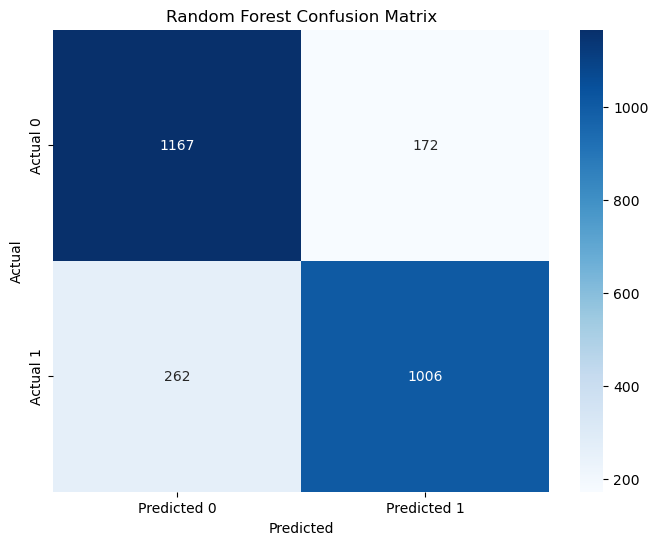

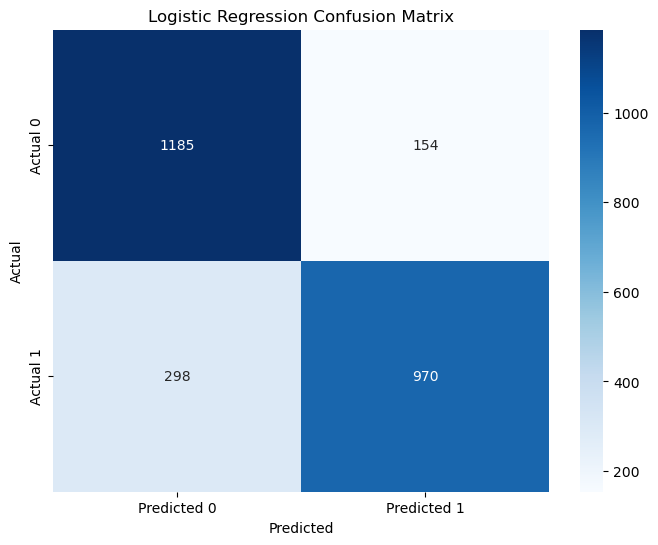

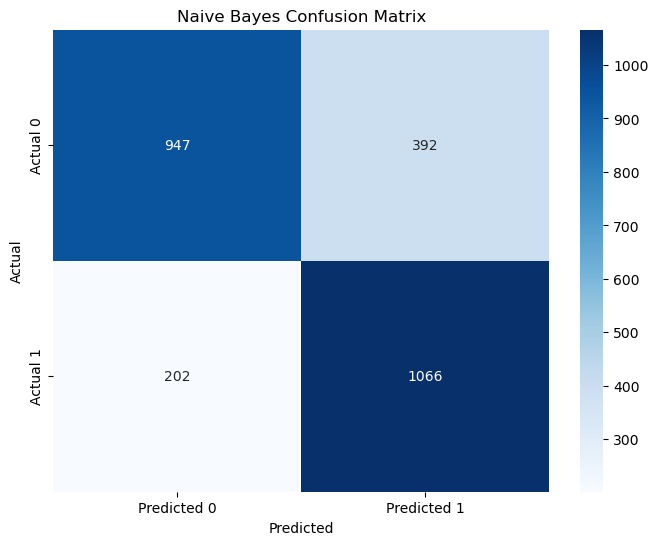

In [72]:
# Random Forest Confusion Matrix
cm_rf = confusion_matrix(y_test, predictions_rf)
plot_confusion_matrix(cm_rf, 'Random Forest Confusion Matrix')

# Logistic Regression Confusion Matrix
cm_lr = confusion_matrix(y_test, predictions_lr)
plot_confusion_matrix(cm_lr, 'Logistic Regression Confusion Matrix')

# Naive Bayes Confusion Matrix
cm_nb = confusion_matrix(y_test, predictions_nb)
plot_confusion_matrix(cm_nb, 'Naive Bayes Confusion Matrix')

plt.show()
